In [1]:
!nvidia-smi

Tue Jul 15 15:08:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import math
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


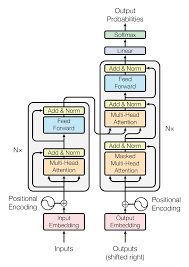

#**Data Preperation**

In [4]:
!git clone https://huggingface.co/datasets/iamTangsang/Nepali-to-English-Translation-Dataset

Cloning into 'Nepali-to-English-Translation-Dataset'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36 (from 1)
Unpacking objects: 100% (36/36), 8.70 KiB | 685.00 KiB/s, done.


In [5]:
train = pd.read_parquet("/content/Nepali-to-English-Translation-Dataset/data/train-00000-of-00001.parquet")

train = train.rename(columns={
    "source": "target",
    "target": "source"
})

In [6]:
train.sample(2)

,target,source
573235,अब भने उनी पार्टी काममा सक्रिय भएका छन् ।,Now he is active in party work.
635830,बच्चा आज अस्पताल बाट डिस्चार्ज भएको छ ।,The child has been discharged from the hospita...


In [7]:
train['source'].unique()[0]

'"No other government agency can use this information, no one in the commonwealth government at all, and in state authorities, only the health officer can use it.'

In [8]:
with open("english_data.txt", "w", encoding="utf-8") as en_file:
    for sentence in train["source"]:
        en_file.write(sentence.strip() + "\n")

with open("nepali_data.txt", "w", encoding="utf-8") as ne_file:
    for sentence in train["target"]:
        ne_file.write(sentence.strip() + "\n")

In [9]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    input="english_data.txt",
    model_prefix="spm_en",
    vocab_size=16000,
    model_type="bpe",  # or "unigram"
    character_coverage=1.0
)

spm.SentencePieceTrainer.train(
    input="nepali_data.txt",
    model_prefix="spm_ne",
    vocab_size=16000,
    model_type="bpe",
    character_coverage=1.0  # Keep it 1.0 for Devanagari scripts
)

In [10]:
# Load English tokenizer
sp_en = spm.SentencePieceProcessor()
sp_en.load("spm_en.model")

# Load Nepali tokenizer
sp_ne = spm.SentencePieceProcessor()
sp_ne.load("spm_ne.model")

en_example = "He is playing football."
ne_example = "उनी फुटबल खेल्दै छन्।"

print("EN Tokens:", sp_en.encode(en_example, out_type=int))
print("NE Tokens:", sp_ne.encode(ne_example, out_type=int))

EN Tokens: [85, 35, 1444, 1395, 15072]
NE Tokens: [67, 1657, 6139, 118, 15634]


In [35]:
def pad_sequence(seq, max_len, pad_id=0):
    return seq + [pad_id] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def tokenize_with_padding(example, max_source_len=28, max_target_len=28):
    source_ids = sp_en.encode(example['source'], out_type=int)
    target_ids = sp_ne.encode(example['target'], out_type=int)

    source_ids = [1] + source_ids + [2]
    target_ids = [1] + target_ids + [2]

    return {
        'source_ids': pad_sequence(source_ids, max_source_len),
        'target_ids': pad_sequence(target_ids, max_target_len)
    }


In [12]:
from datasets import Dataset

dataset = Dataset.from_pandas(train)  # your df with source & target columns
tokenized_dataset = dataset.map(tokenize_with_padding, remove_columns=['source', 'target'])

Map:   0%|          | 0/702697 [00:00<?, ? examples/s]

In [13]:
tokenized_dataset

Dataset({
    features: ['source_ids', 'target_ids'],
    num_rows: 702697
})

In [38]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataset):  # dataset = HuggingFace dataset
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]  # Access a single row as a dict
        return {
            'source_ids': torch.tensor(item['source_ids'], dtype=torch.long),
            'target_ids': torch.tensor(item['target_ids'], dtype=torch.long),
        }

In [15]:
# Use it like this:
train_dataset = CustomDataset(tokenized_dataset)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [16]:
train_dataset[3]

{'source_ids': tensor([    1,   142, 15106,   298,    35,    78,     5,  1090, 15072,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]),
 'target_ids': tensor([   1, 4575,  689,  199, 1078,  340,   12,    2,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0])}

In [17]:
train_loader

#**Transformer Part Start**

In [11]:
class Embedding(nn.Module):
    def __init__(self, config, max_len=5000):
        super().__init__()
        self.token_embedding = nn.Embedding(config.vocab_size, config.emb_dim)

        pe = torch.zeros(max_len, config.emb_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, config.emb_dim, 2).float() * (-math.log(10000.0) / config.emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, emb_dim]
        self.register_buffer('pe', pe)

    def forward(self, input_ids):
        B, T = input_ids.shape
        token_embeds = self.token_embedding(input_ids)  # [B, T, D]
        pos_embeds = self.pe[:, :T, :]                  # [1, T, D]
        return token_embeds + pos_embeds                # [B, T, D]

In [12]:
class AttentionsHead(nn.Module):

  def __init__(self, config):

    super().__init__()
    self.n_heads = config.num_attention_heads
    self.embed_dim = config.hidden_size
    self.dropout = config.attention_dropout

    self.q_mat = nn.Linear(self.embed_dim, self.embed_dim)
    self.k_mat = nn.Linear(self.embed_dim, self.embed_dim)
    self.v_mat = nn.Linear(self.embed_dim, self.embed_dim)
    self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

  def forward(self, hidden_states):

    # hidden states are the embeddings of the patches of dim: [1, 196, 768]

    B, T, C = hidden_states.shape
    q_states = self.q_mat(hidden_states)
    k_states = self.k_mat(hidden_states)
    v_states = self.v_mat(hidden_states)

   # print(f"Shape of Q,K, V is: {q_states.shape}")

    q_states = q_states.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)
    k_states = k_states.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)
    v_states = v_states.view(B, T, self.n_heads, C // self.n_heads).transpose(1,2)

   # print(f"Shape of Q,K, V is: {q_states.shape}")

    attn_weights = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))

   # print(f"Shape of attention score is: {attn_weights.shape}")

    attn_weights = F.softmax(attn_weights, dim = -1).to(q_states.dtype)
    attn_weights = F.dropout(attn_weights, p = self.dropout, training=self.training)

    attn_outs = attn_weights @ v_states

   # print(f"Shape of attention score is: {attn_outs.shape}")
    attn_outs = attn_outs.transpose(1,2)
   # print(f"Shape of attention score is: {attn_outs.shape}")

    attn_outs = attn_outs.reshape(B, T, C).contiguous()
    attn_outs = self.out_proj(attn_outs)
    return attn_outs

In [13]:
class FFNN(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
    self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

  def forward(self, hidden_states: torch.Tensor):

    hidden_states = self.fc1(hidden_states)
    hidden_states = F.gelu(hidden_states, approximate = 'tanh')
    hidden_states = self.fc2(hidden_states)
    return hidden_states

#**ENCODER**

In [14]:
class Encoder(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.config = config
    self.attentionHead = AttentionsHead(config)
    self.layer_norm1 = nn.LayerNorm(config.emb_dim, eps = config.layer_norm_eps)
    self.layer_norm2 = nn.LayerNorm(config.emb_dim, eps = config.layer_norm_eps)
    self.ffnn = FFNN(config)


  def forward(self, embeddings):

    residual = embeddings
    embeddings = self.layer_norm1(embeddings)
    embeddings = self.attentionHead(embeddings)
    embeddings = residual + embeddings

    residual = embeddings
    embeddings = self.layer_norm2(embeddings)
    embeddings = self.ffnn(embeddings)
    embeddings = embeddings + residual


    return embeddings

In [15]:
class EEncoder(nn.ModuleList):

  def __init__(self, config):
    super().__init__()
    self.layers = nn.ModuleList(Encoder(config=config) for _ in range(config.n_block))

  def forward(self, embeddings):
    for layer in self.layers:
      output = layer(embeddings)
    return output

In [16]:
class CompleteEncoder(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.all_layers = EEncoder(config=config)
    self.post_layernorm = nn.LayerNorm(config.emb_dim, eps=config.layer_norm_eps)

  def forward(self, x):

    ffnn_outputs = self.all_layers(x)
    normalised_outputs = self.post_layernorm(ffnn_outputs)

    return normalised_outputs

#**DECODER**

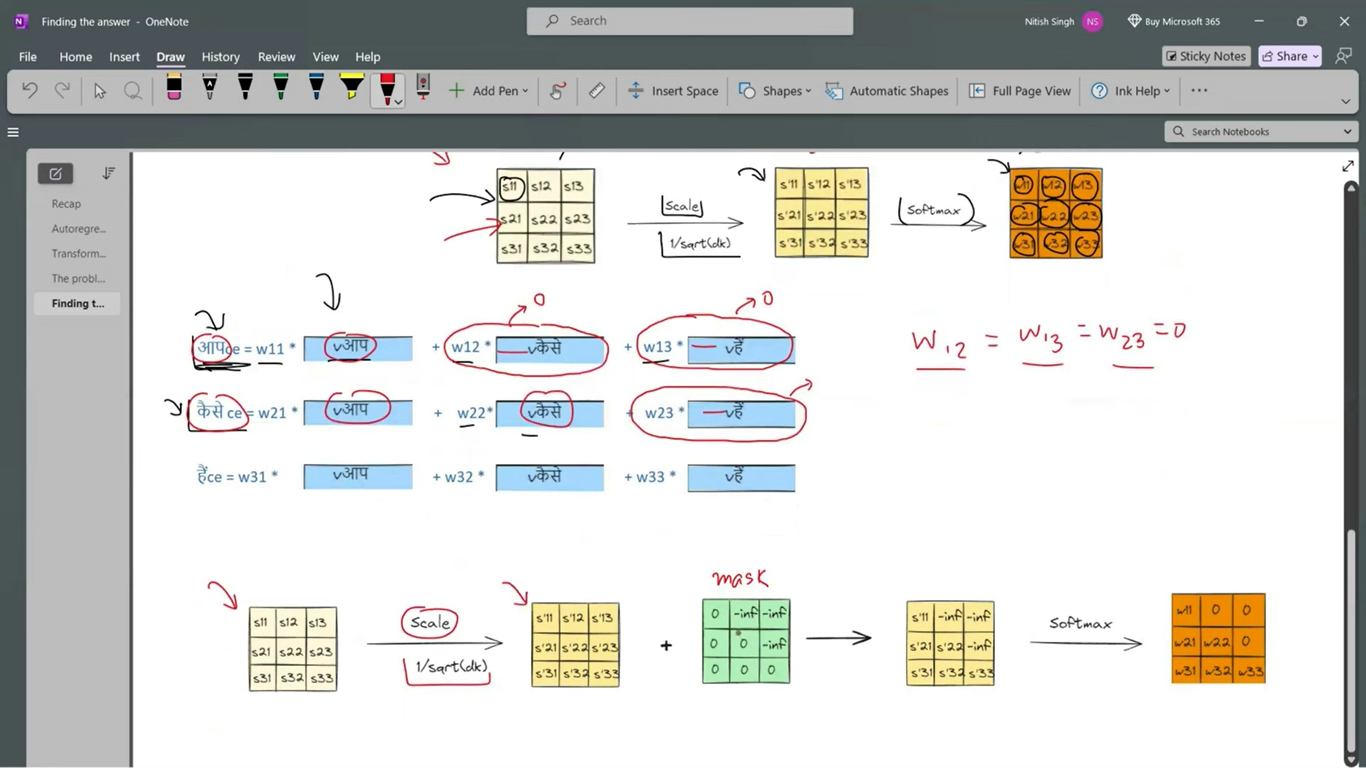

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MaskedMultiHeadAttn(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.q_mat = nn.Linear(config.emb_dim, config.emb_dim)
    self.k_mat = nn.Linear(config.emb_dim, config.emb_dim)
    self.v_mat = nn.Linear(config.emb_dim, config.emb_dim)
    self.out_mat = nn.Linear(config.emb_dim, config.emb_dim)
    self.n_heads = config.num_attention_heads

  def forward(self, embedding):

    B, T, C = embedding.shape

    adds = torch.triu(torch.ones(T, T, device=embedding.device), diagonal=1)
    masks = adds.masked_fill(adds == 1, float('-inf'))  # [T, T] causal mask

    query = self.q_mat(embedding)
    key   = self.k_mat(embedding)
    value = self.v_mat(embedding)

    query = query.view(B, T, self.n_heads, C // self.n_heads).transpose(2, 1)  # [B, H, T, C/H]
    key   = key.view(B, T, self.n_heads, C // self.n_heads).transpose(2, 1)
    value = value.view(B, T, self.n_heads, C // self.n_heads).transpose(2, 1)

    attn_score = (query @ key.transpose(-2, -1)) * (1.0 / math.sqrt(key.size(-1)))  # [B, H, T, T]

    masked_attn_score = attn_score + masks  # broadcast [T, T] over [B, H, T, T]

    softmaxed_attn_score = F.softmax(masked_attn_score, dim=-1)

    embeddings = softmaxed_attn_score @ value  # [B, H, T, C/H]
    embeddings = embeddings.transpose(2, 1).reshape(B, T, C)  # [B, T, C]
    embeddings = self.out_mat(embeddings)

    return embeddings


In [18]:
class CrossMHA(nn.Module):

  def __init__(self, config):

    super().__init__()
    self.n_heads = config.num_attention_heads
    self.q_mat = nn.Linear(config.emb_dim, config.emb_dim)
    self.k_mat = nn.Linear(config.emb_dim, config.emb_dim)
    self.v_mat = nn.Linear(config.emb_dim, config.emb_dim)
    self.out_mat = nn.Linear(config.emb_dim, config.emb_dim)

  def forward(self, embeddingsFromEncoder, embeddingsFromDecoder):

    B, T, C = embeddingsFromDecoder.shape
    T_enc = embeddingsFromEncoder.shape[1]

    query = self.q_mat(embeddingsFromDecoder)
    key   = self.k_mat(embeddingsFromEncoder)
    value = self.v_mat(embeddingsFromEncoder)

    # [ B, T, H, C] --> [ B, H, T, C]

    query = query.view(B, T, self.n_heads, C // self.n_heads).transpose(2,1)
    key   = key.view(B, T_enc, self.n_heads, C // self.n_heads).transpose(2,1)
    value = value.view(B, T_enc, self.n_heads, C // self.n_heads).transpose(2,1)

    attn_score = (query @ key.transpose(-2, -1)) * (1.0 / math.sqrt(key.size(-1)))   # [B, H, T_dec, T_enc]

    softmaxed_attn_score = F.softmax(attn_score, dim = -1)

    embeddings = softmaxed_attn_score @ value  # [ B, H, T, n_heads] But we need to make [B, T, C] where C = T * n_heads. So::

    embeddings = embeddings.transpose(2,1)     # [ B, T, H, n_heads]
    embeddings = embeddings.reshape(B, T, C)

    embeddings = self.out_mat(embeddings)

    return embeddings

In [19]:
class DecoderBlock(nn.Module):

  def __init__(self, config):
    super().__init__()
    self.MaskedMHA = MaskedMultiHeadAttn(config)
    self.CrossMHA  = CrossMHA(config)
    self.norm_layer1 = nn.LayerNorm(config.emb_dim, eps = config.layer_norm_eps)
    self.norm_layer2 = nn.LayerNorm(config.emb_dim, eps = config.layer_norm_eps)
    self.norm_layer3 = nn.LayerNorm(config.emb_dim, eps = config.layer_norm_eps)
    self.ffnn = FFNN(config)


  def forward(self, embeddings, EncodersOutput):

    residuals = embeddings
    embeddings = self.MaskedMHA(embeddings)
    embeddings = embeddings + residuals
    normalised_embeddings = self.norm_layer1(embeddings)

    residuals = normalised_embeddings
    embeddings = self.CrossMHA(embeddingsFromEncoder = EncodersOutput, embeddingsFromDecoder = normalised_embeddings)
    embeddings = embeddings + residuals
    normalised_embeddings = self.norm_layer2(embeddings)

    residuals = normalised_embeddings
    embeddings = self.ffnn(normalised_embeddings)
    embeddings = embeddings + residuals
    normalised_embeddings = self.norm_layer3(embeddings)

    return normalised_embeddings

In [20]:
class CompleteDecoder(nn.Module):

  def __init__(self, config):

    super().__init__()
    self.layers = nn.ModuleList(DecoderBlock(config) for _ in range(config.n_block))

  def forward(self, embeddings, encodersOutput):
    for layer in self.layers:
      output = layer(embeddings, encodersOutput)
      embeddings = output
    return output

#**Single Transformer Block**

In [21]:
class ConfigParams:
    emb_dim: int = 256                # Model dimension d_model
    hidden_size: int = 256            # Same as emb_dim
    intermediate_size: int = 512     # FFN hidden layer size
    num_attention_heads: int = 4      # Number of heads (d_model must be divisible by this)
    layer_norm_eps: float = 1e-6      # Layer norm epsilon
    attention_dropout: float = 0.1    # Dropout for attention weights
    vocab_size: int = 16000           # Typical size in original paper for WMT tasks
    n_block: int = 4                  # Number of encoder and decoder layers
    max_seq_len: int = 128            # Positional encoding length
    dropout: float = 0.0              # Dropout in all layers
    epochs: int = 10                  # Can be adjusted as needed

config = ConfigParams()

In [22]:
class TransformerBlock(nn.Module):

  def __init__(self, config):

    super().__init__()
    self.embedding = Embedding(config = config)
    self.Encoder = CompleteEncoder(config = config)
    self.Decoder = CompleteDecoder(config = config)
    self.LastFFNN = nn.Linear(config.emb_dim, config.vocab_size)


  def forward(self, source_ids, target_ids):

    source_embeddings = self.embedding(source_ids)
    target_embeddings = self.embedding(target_ids)

    Encoders_output = self.Encoder(source_embeddings)
    Decoders_output = self.Decoder(target_embeddings, Encoders_output)

    logits = self.LastFFNN(Decoders_output)

    return logits

#**TRAINING LOOP**

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"--> {device.upper()} is used")

--> CUDA is used


In [38]:
model = TransformerBlock(config = config)
model = model.to(device)

In [39]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, weight_decay = 0.01)

In [40]:
import os
from tqdm import tqdm
from google.colab import drive

# 📌 Mount Google Drive
drive.mount('/content/drive')

# 📁 Create folder for checkpoints
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# 🔁 Resume if a checkpoint exists
def load_checkpoint(model, optimizer):
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
    if checkpoints:
        latest = checkpoints[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest)
        print(f"✅ Loading checkpoint: {latest}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        return checkpoint['epoch'] + 1
    return 0

#  Training loop
start_epoch = load_checkpoint(model, optimizer)
model.train()

for epoch in range(start_epoch, config.epochs):
    total_loss = 0.0
    print(f"\n🔁 Epoch {epoch + 1}/{config.epochs}")

    for batch in tqdm(train_loader):
        source = batch['source_ids'].to(device)
        target = batch['target_ids'].to(device)

        # Shift target for decoder
        decoder_input = target[:, :-1]
        decoder_target = target[:, 1:]

        # Forward pass
        output = model(source_ids=source, target_ids=decoder_input)

        # Reshape for loss
        output = output.reshape(-1, output.size(-1))        # [B*T, vocab_size]
        decoder_target = decoder_target.reshape(-1)         # [B*T]

        loss = criterion(output, decoder_target)
        total_loss += loss.item()

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f" Average Loss: {avg_loss:.4f}")

    # 💾 Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch + 1}.pth")
    torch.save(checkpoint, checkpoint_path)
    print(f"📦 Checkpoint saved: {checkpoint_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🔁 Epoch 1/10


100%|██████████| 2745/2745 [06:09<00:00,  7.42it/s]


 Average Loss: 5.8982
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_1.pth

🔁 Epoch 2/10


100%|██████████| 2745/2745 [06:21<00:00,  7.20it/s]


 Average Loss: 4.7038
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_2.pth

🔁 Epoch 3/10


100%|██████████| 2745/2745 [06:22<00:00,  7.17it/s]


 Average Loss: 4.1570
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_3.pth

🔁 Epoch 4/10


100%|██████████| 2745/2745 [06:22<00:00,  7.17it/s]


 Average Loss: 3.8007
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_4.pth

🔁 Epoch 5/10


100%|██████████| 2745/2745 [06:22<00:00,  7.18it/s]


 Average Loss: 3.5527
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_5.pth

🔁 Epoch 6/10


100%|██████████| 2745/2745 [06:22<00:00,  7.18it/s]


 Average Loss: 3.3690
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_6.pth

🔁 Epoch 7/10


100%|██████████| 2745/2745 [06:22<00:00,  7.18it/s]


 Average Loss: 3.2244
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_7.pth

🔁 Epoch 8/10


100%|██████████| 2745/2745 [06:22<00:00,  7.18it/s]


 Average Loss: 3.1059
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_8.pth

🔁 Epoch 9/10


100%|██████████| 2745/2745 [06:23<00:00,  7.17it/s]


 Average Loss: 3.0054
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_9.pth

🔁 Epoch 10/10


100%|██████████| 2745/2745 [06:23<00:00,  7.17it/s]


 Average Loss: 2.9186
📦 Checkpoint saved: /content/drive/MyDrive/checkpoints/epoch_10.pth


#**PREDICTION TIME**

In [24]:
config = ConfigParams()
model = TransformerBlock(config= config)

checkpoint = torch.load("/content/drive/MyDrive/checkpoints/epoch_10.pth", map_location = device)
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [25]:
model = model.to(device)
model.eval()

TransformerBlock(
  (embedding): Embedding(
    (token_embedding): Embedding(16000, 256)
  )
  (Encoder): CompleteEncoder(
    (all_layers): EEncoder(
      (0): ModuleList(
        (0-3): 4 x Encoder(
          (attentionHead): AttentionsHead(
            (q_mat): Linear(in_features=256, out_features=256, bias=True)
            (k_mat): Linear(in_features=256, out_features=256, bias=True)
            (v_mat): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (layer_norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (layer_norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (ffnn): FFNN(
            (fc1): Linear(in_features=256, out_features=512, bias=True)
            (fc2): Linear(in_features=512, out_features=256, bias=True)
          )
        )
      )
    )
    (post_layernorm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  )
  

In [26]:
def predict(input_sentence):

  model.eval()

  input_ids = sp_en.encode(input_sentence, out_type=int)
  input_ids = [1] + input_ids + [2]  # Add <sos>, <eos>

  # Pad/truncate to fixed length
  max_len = 32
  if len(input_ids) < max_len:
      input_ids += [0] * (max_len - len(input_ids))  # pad with 0
  else:
      input_ids = input_ids[:max_len]  # truncate if too long

  # Convert to tensor
  input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)

  decoder_output = [1]

  with torch.no_grad():

    for _ in range(32):

      output_tensor = torch.tensor([decoder_output]).to(device)

      next_digit_logits = model(input_ids, output_tensor)

      next_digit_logits = next_digit_logits[:, -1, :]  # selecting the last token

      predicted_token = F.softmax(next_digit_logits, dim = -1)

      next_token = torch.argmax(next_digit_logits, dim = -1).item()

      decoder_output.append(next_token)

      if next_token == 2:
        break


  return sp_ne.decode(decoder_output[1:])

In [66]:
predict("Hi there I am from Nepal.")

'म नेपाल आएको हुँ ।'

In [51]:
from datasets import Dataset

test = pd.read_parquet("/content/Nepali-to-English-Translation-Dataset/data/test-00000-of-00001.parquet")

test = test.rename(columns={
    "source": "target",
    "target": "source"
})

In [52]:
dataset = Dataset.from_pandas(test)  # your df with source & target columns
tokenized_dataset = dataset.map(tokenize_with_padding, remove_columns=['source', 'target'])

Map:   0%|          | 0/10867 [00:00<?, ? examples/s]

In [54]:
# Use it like this:
test_dataset = CustomDataset(tokenized_dataset)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [55]:
model.eval()

from tqdm import tqdm

predicted_sentences = []

with torch.no_grad():
    for batches in tqdm(test_loader):
        input_ids_batch = batches['source_ids'].to(device)  # [B, T]
        batch_size = input_ids_batch.size(0)

        for i in range(batch_size):
            input_ids = input_ids_batch[i].unsqueeze(0)  # shape: [1, T]
            decoder_output = [1]  # Start with <sos>

            for _ in range(32):
                output_tensor = torch.tensor([decoder_output], dtype=torch.long).to(device)

                logits = model(input_ids, output_tensor)  # [1, T', vocab_size]
                logits = logits[:, -1, :]  # Get last token logits

                next_token = torch.argmax(logits, dim=-1).item()
                decoder_output.append(next_token)

                if next_token == 2:  # <eos>
                    break

            decoded_text = sp_ne.decode(decoder_output[1:])  # skip <sos>
            predicted_sentences.append(decoded_text)

100%|██████████| 43/43 [14:05<00:00, 19.67s/it]


In [56]:
predicted_sentences[1000]

'मलाई थाहा थियो, उनीहरू आफैँका हुन् ।'

In [60]:
actual_sentences = list(test['target'])
actual_sentences[0]

'यसबाट युवकहरु पनि पीडित भएको देखिन्छन ।'

In [83]:
print(f'''Predicted: {predicted_sentences[21]} \nActual: {actual_sentences[21]}''')

Predicted: अन्य नीतिगत चुनौतीहरू पनि छन् । 
Actual: अर्को नीतिगत चुनौतीहरू पनि छन्।


In [77]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method4
bleu_scores = []

for ref, pred in zip(actual_sentences, predicted_sentences):
    ref_tokens = ref.strip().split()
    pred_tokens = pred.strip().split()

    score = sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5 , 0.5, 0), smoothing_function=smooth)
    bleu_scores.append(score)

average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"\n Average BLEU score: {average_bleu * 100 :.2f}%")


 Average BLEU score: 23.40%
